In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score

import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from evaluation import al_results
import scienceplots
import pandas as pd
import seaborn as sns

plt.style.use("science")

In [6]:
import sys 
sys.path.append("..")

from synthetic_anomalies.generation import anomaly_dataset

## create a dataset with both normal samples and synthetic anomalies, generated 
## by utilizing the Gaussian mixture model trained on LSST simulation data -MEW
output = anomaly_dataset(
    anom_size=1000
)

## apply a mask to the global anomalies in the generated data set to select only the samples
## that have log-likelihood score >= 0, and all normal samples with label 0 -MEW
global_df = output[~((output["label"] == 1) & (output["score"] >= 0)) & ((output["label"] == 1) | (output["label"] == 0))]

## determine what percentage of the (now-filtered) dataset consists of global anomalies -MEW
contamination_global = len(global_df[global_df["label"] == 1])/len(global_df)

## convert dataset with global anomalies filtered to a numpy array -MEW
global_df = global_df.to_numpy()

## select all local anomalies and normal samples -- no log likelihood score filter on this one, 
## because local outliers are sampled from the model's components  -MEW
local_df = output[(output["label"] == 0) | (output["label"] == 2)].to_numpy()

## determine what percentage of the (local-anomaly filtered) dataset consists of local anomalies -MEW
contamination_local = len(output[output["label"] == 2])/len(local_df)

## apply a mask to the cluster anomalies in the generated data set to select only the samples
## that have log-likelihood score >= 0, and all normal samples with label 0 -MEW
cluster_df = output[~((output["label"] == 3) & (output["score"] >= 0)) & ((output["label"] == 3) | (output["label"] == 0))]

## determine what percentage of the (now-filtered) dataset consists of cluster anomalies -MEW
contamination_cluster = len(cluster_df[cluster_df["label"] == 3])/len(cluster_df)

## convert dataset with cluster anomalies filtered to a numpy array -MEW
cluster_df = cluster_df.to_numpy()

Global anomaly active learning

In [7]:
## Calculate how accurately the XGBoost classifier can determine what is an anomaly and what isn't, 
## as a function of how many training labels are given; F1 and balanced accuracy scores are used here -MEW
glob_label_counts, glob_acc_scores, glob_f1_scores = al_results(
    data = global_df,
    label = 1
)

In [8]:
## below is the best unsupervised balanced accuracy and F1 scores for global anomalies;
## note that both were achieved by the KNN method (see Table 1 in Rogers 2024) 
best_unsupervised_acc = 0.812
best_unsupervised_f1 = 0.623

## below is the upper quartile of the unsupervised balanced accuracy and F1 scores for global anomalies,
## calculated from Table 1 data
upper_quartile_unsupervised_acc = 0.724203
upper_quartile_unsupervised_f1 = 0.449354

/home/ellie/src/anaconda3/envs/lsst/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ellie/src/anaconda3/envs/lsst/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ellie/src/anaconda3/envs/lsst/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ellie/src/anaconda3/envs/lsst/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Text(0.5, 0.01, 'Positive anomaly training labels available to classifier')

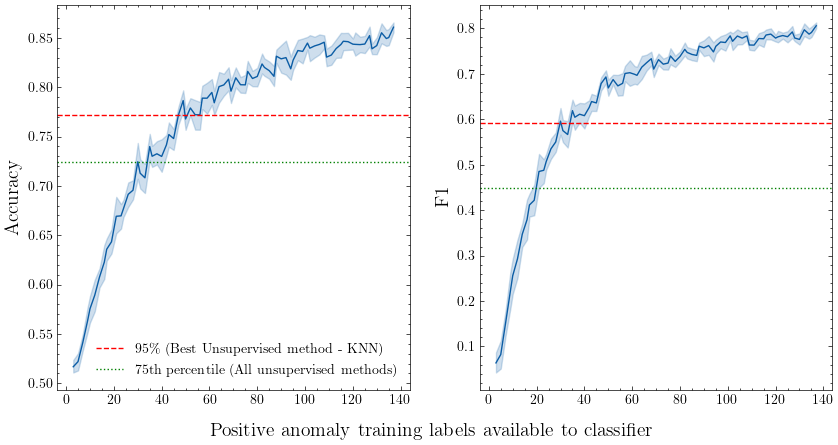

In [9]:
## Convert data from XGBoost into a Pandas dataframe with labelled columns -MEW
rows = []
for idx, (i, j, k) in enumerate(zip(glob_label_counts, glob_acc_scores, glob_f1_scores)):
    for l in range(10):
        rows.append([i, j[l], k[l]])

data = pd.DataFrame(rows, columns = ["labels", "acc", "f1"])

## plot the results from XGBoost and customize the figure produced -MEW
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.lineplot(
    data = data,
    x = "labels",
    y = "acc",
    ax = ax[0],
)
ax[0].set_ylabel("Accuracy", fontsize = 14)
ax[0].set_xlabel("")

ax[0].axhline(best_unsupervised_acc*0.95, c="r", ls="--", label=r"95$\%$ (Best Unsupervised method - KNN)")
ax[0].axhline(upper_quartile_unsupervised_acc, c="g", ls=":", label="75th percentile (All unsupervised methods)")


sns.lineplot(
    data = data,
    x = "labels",
    y = "f1",
    ax = ax[1]
)

ax[1].set_ylabel("F1", fontsize = 14)
ax[1].set_xlabel("")
ax[1].axhline(best_unsupervised_f1*0.95, c="r", ls="--")

ax[1].axhline(upper_quartile_unsupervised_f1, c="green", ls=":", label="75th percentile of unsupervised methods")

ax[0].legend(loc="lower right", fontsize=10)
fig.supxlabel("Positive anomaly training labels available to classifier", fontsize=14)

#plt.savefig("al_.png", dpi=300)

In [17]:
## determine the number of labels needed to achieve 90%, 95%, and 100% of the balanced accuracy scores achieved by
## the best unsupervised anomaly detection method (KNN in this case) -MEW
print("How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?")
print(f"90% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > 0.9*best_unsupervised_acc)[0][0]]} labels")
print(f"95% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > 0.95*best_unsupervised_acc)[0][0]]} labels")
print(f"100% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > best_unsupervised_acc)[0][0]]} labels")

How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?
90% accuracy of the kNN: 35.0 labels
95% accuracy of the kNN: 47.0 labels
100% accuracy of the kNN: 76.0 labels


In [18]:
## determine the number of labels needed to achieve 90%, 95%, and 100% of the F1 scores achieved by
## the best unsupervised anomaly detection method (KNN in this case) -MEW
print("How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?")
print(f"90% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > 0.9*best_unsupervised_f1)[0][0]]} labels")
print(f"95% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > 0.95*best_unsupervised_f1)[0][0]]} labels")
print(f"100% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > best_unsupervised_f1)[0][0]]} labels")

How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?
90% f1 of the kNN: 30.0 labels
95% f1 of the kNN: 30.0 labels
100% f1 of the kNN: 42.0 labels
